In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline
from datetime import datetime

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt


In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sample = pd.read_csv('sample_submission.csv')

In [6]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


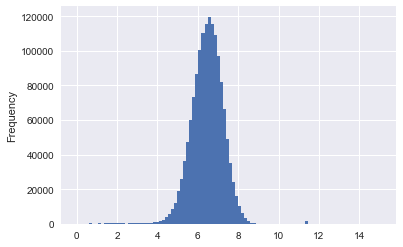

In [8]:
df_train['log_trip_duration'] = np.log(df_train['trip_duration'].values)
df_train['log_trip_duration'].plot.hist(bins=100)

In [9]:
df_train['trip_duration'].max()/3600

979.52277777777783

For some reason there is a trip that lasts nearly 1000 hours

In [10]:
df_train['trip_duration'].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

The average trip lasts 959 seconds or 16 minutes

# here we convert date time like data to datetime 

In [11]:
df_train['pickup_datetime'] = pd.to_datetime(df_train.pickup_datetime)
df_test['pickup_datetime'] = pd.to_datetime(df_test.pickup_datetime)
df_train.loc[:, 'pickup_date'] = df_train['pickup_datetime'].dt.date
df_test.loc[:, 'pickup_date'] = df_test['pickup_datetime'].dt.date
df_train['dropoff_datetime'] = pd.to_datetime(df_train.dropoff_datetime)
df_train['store_and_fwd_flag'] = 1 * (df_train.store_and_fwd_flag.values == 'Y')
df_test['store_and_fwd_flag'] = 1 * (df_test.store_and_fwd_flag.values == 'Y')
df_train['check_trip_duration'] = (df_train['dropoff_datetime'] - df_train['pickup_datetime']).map(lambda x: x.total_seconds())
duration_difference = df_train[np.abs(df_train['check_trip_duration'].values  - df_train['trip_duration'].values) > 1]
print('Trip_duration and datetimes are ok.') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('Ooops.')

Trip_duration and datetimes are ok.


In [12]:
df_train.loc[:, 'pickup_weekday'] = df_train['pickup_datetime'].dt.weekday
df_train.loc[:, 'pickup_hour_weekofyear'] = df_train['pickup_datetime'].dt.weekofyear
df_train.loc[:, 'pickup_hour'] = df_train['pickup_datetime'].dt.hour
df_train.loc[:, 'pickup_minute'] = df_train['pickup_datetime'].dt.minute
df_train.loc[:, 'pickup_dt'] = (df_train['pickup_datetime'] - df_train['pickup_datetime'].min()).dt.total_seconds()
df_train.loc[:, 'pickup_week_hour'] = df_train['pickup_weekday'] * 24 + df_train['pickup_hour']

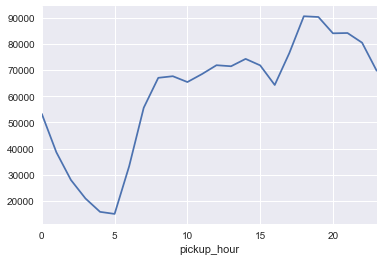

In [13]:
df_train.groupby(['pickup_hour']).size().plot.line()

In [14]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_date,check_trip_duration,pickup_weekday,pickup_hour_weekofyear,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,6.120297,2016-03-14,455.0,0,11,17,24,6369878.0,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,6.496775,2016-06-12,663.0,6,23,0,43,14085798.0,144
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,7.661056,2016-01-19,2124.0,1,3,11,35,1596907.0,35
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,6.061457,2016-04-06,429.0,2,14,19,32,8364734.0,67
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,6.075346,2016-03-26,435.0,5,12,13,30,7392638.0,133


In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 20 columns):
id                        1458644 non-null object
vendor_id                 1458644 non-null int64
pickup_datetime           1458644 non-null datetime64[ns]
dropoff_datetime          1458644 non-null datetime64[ns]
passenger_count           1458644 non-null int64
pickup_longitude          1458644 non-null float64
pickup_latitude           1458644 non-null float64
dropoff_longitude         1458644 non-null float64
dropoff_latitude          1458644 non-null float64
store_and_fwd_flag        1458644 non-null int64
trip_duration             1458644 non-null int64
log_trip_duration         1458644 non-null float64
pickup_date               1458644 non-null object
check_trip_duration       1458644 non-null float64
pickup_weekday            1458644 non-null int64
pickup_hour_weekofyear    1458644 non-null int64
pickup_hour               1458644 non-null int64
pickup_minute         

In [16]:
df_forest = df_train.drop(df_train.columns[[0,2,3,5,6,7,8,9,12,13]],axis=1)
df_forest.head()

,vendor_id,passenger_count,trip_duration,log_trip_duration,pickup_weekday,pickup_hour_weekofyear,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour
0,2,1,455,6.120297,0,11,17,24,6369878.0,17
1,1,1,663,6.496775,6,23,0,43,14085798.0,144
2,2,1,2124,7.661056,1,3,11,35,1596907.0,35
3,2,1,429,6.061457,2,14,19,32,8364734.0,67
4,2,1,435,6.075346,5,12,13,30,7392638.0,133


from sklearn.model_selection import train_test_split

X = df_forest.drop('trip_duration',axis=1)
y = df_forest['trip_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()

dtree.fit(X_train,y_train)

predictions = dtree.predict(X_test)

from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test,predictions))

print(confusion_matrix(y_test,predictions))

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=600)

# Clustering to Display the Neighbourhoods

In [21]:
coords = np.vstack((df_train[['pickup_latitude', 'pickup_longitude']].values,
                    df_train[['dropoff_latitude', 'dropoff_longitude']].values,
                    df_test[['pickup_latitude', 'pickup_longitude']].values,
                    df_test[['dropoff_latitude', 'dropoff_longitude']].values))

In [22]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [26]:
t0 = datetime.now()
df_train.loc[:, 'pickup_cluster'] = kmeans.predict(df_train[['pickup_latitude', 'pickup_longitude']])
df_train.loc[:, 'dropoff_cluster'] = kmeans.predict(df_train[['dropoff_latitude', 'dropoff_longitude']])
df_test.loc[:, 'pickup_cluster'] = kmeans.predict(df_test[['pickup_latitude', 'pickup_longitude']])
df_test.loc[:, 'dropoff_cluster'] = kmeans.predict(df_test[['dropoff_latitude', 'dropoff_longitude']])
t1 = datetime.now()
print('Custering Time: %i seconds' % (t1 - t0).seconds)

Custering Time: 5 seconds


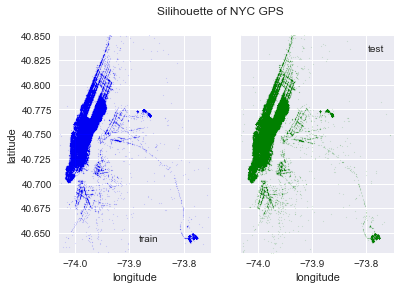

In [28]:
N = 100000
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(df_train['pickup_longitude'].values[:N], df_train['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(df_test['pickup_longitude'].values[:N], df_test['pickup_latitude'].values[:N],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Silihouette of NYC GPS')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

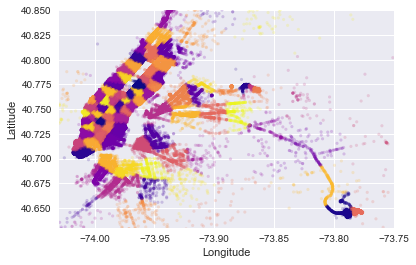

In [30]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(df_train.pickup_longitude.values[:500000], df_train.pickup_latitude.values[:500000], s=10, lw=0,
           c=df_train.pickup_cluster[:500000].values, cmap='plasma', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()